# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Compute the $Q_0$

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
from mltier1 import Field, Q_0, parallel_process, describe

In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [5]:
from IPython.display import clear_output

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Area limits

In [7]:
# Busy week Hatfield 2017
ra_down = 170.
ra_up = 190.
dec_down = 46.8
dec_up = 55.9

In [8]:
field = Field(170.0, 190.0, 46.8, 55.9)

## Load data

In [9]:
combined = Table.read("pw.fits")

In [10]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_merge_ID_optical_v0.8.fits")

In [11]:
np.array(combined.colnames)

array(['AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr', 'W1mag',
       'W1magErr', 'i', 'iErr'],
      dtype='<U8')

In [12]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Peak_flux',
       'E_Peak_flux', 'Total_flux', 'E_Total_flux', 'Maj', 'E_Maj', 'Min',
       'E_Min', 'DC_Maj', 'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'PA', 'E_PA',
       'DC_PA', 'E_DC_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID',
       'Masked_Fraction', 'ID_flag', 'ID_name', 'ID_ra', 'ID_dec', 'ML_LR',
       'LGZ_Size', 'LGZ_Width', 'LGZ_PA', 'LGZ_Assoc', 'LGZ_Assoc_Qual',
       'LGZ_ID_Qual', 'AllWISE', 'objID', 'gFApFlux', 'gFApFluxErr',
       'gFApMag', 'gFApMagErr', 'rFApFlux', 'rFApFluxErr', 'rFApMag',
       'rFApMagErr', 'iFApFlux', 'iFApFluxErr', 'iFApMag', 'iFApMagErr',
       'zFApFlux', 'zFApFluxErr', 'zFApMag', 'zFApMagErr', 'yFApFlux',
       'yFApFluxErr', 'yFApMag', 'yFApMagErr', 'w1Flux', 'w1FluxErr',
       'w1Mag', 'w1MagErr', 'w2Flux', 'w2FluxErr', 'w2Mag', 'w2MagErr',
       'w3Flux', 'w3FluxErr', 'w3Mag', 'w3MagErr', 'w4Flux', 'w4FluxErr',
       'w4Mag', 'w4MagErr', 'XrayClass', '2RXS_ID', 'XMMSL2_ID', 'IRClass',
 

### Filter catalogues

In [13]:
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]

In [14]:
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.) &
                                         (lofar_aux['ID_flag'] == 1)], 
                               colnames=("RA", "DEC"))

### Sky coordinates

In [15]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [16]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Summary of galaxy types in the combined catalogue

In [17]:
combined_matched = (~np.isnan(combined["i"]) & 
                    ~np.isnan(combined["W1mag"]))
np.sum(combined_matched) # Matches

8196213

In [18]:
combined_panstarrs = (~np.isnan(combined["i"]) & 
                      np.isnan(combined["W1mag"]))
np.sum(combined_panstarrs) # Only PanSTARSS

13454849

In [19]:
combined_wise =(np.isnan(combined["i"]) & 
                ~np.isnan(combined["W1mag"]))
np.sum(combined_wise) # Only WISE

5023475

In [20]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise

## $Q_0$ dependence on the radius

We will iterate 10 times for each radius. However, the error is so small that a direct computation can be accurate to 4 significant figures.

In [21]:
n_iter = 10

In [22]:
rads = list(range(1,26))

### i-band

In [23]:
q_0_comp_i = Q_0(coords_lofar, coords_combined[combined_i], field)

In [24]:
q_0_rad_i = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_i(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_i.append(np.mean(q_0_rad_aux))
    print("{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(radius, 
            np.mean(q_0_rad_aux), np.std(q_0_rad_aux), 
            np.min(q_0_rad_aux), np.max(q_0_rad_aux)))

 1 0.39416 +/- 0.00018 [0.39395 0.39453]
 2 0.48341 +/- 0.00015 [0.48313 0.48368]
 3 0.50341 +/- 0.00029 [0.50283 0.50389]
 4 0.51244 +/- 0.00057 [0.51171 0.51382]
 5 0.51767 +/- 0.00047 [0.51698 0.51835]
 6 0.52033 +/- 0.00074 [0.51903 0.52178]
 7 0.52212 +/- 0.00072 [0.52085 0.52325]
 8 0.52557 +/- 0.00093 [0.52453 0.52728]
 9 0.52914 +/- 0.00102 [0.52748 0.53145]
10 0.53035 +/- 0.00071 [0.52862 0.53130]
11 0.53297 +/- 0.00227 [0.52914 0.53675]
12 0.53529 +/- 0.00171 [0.53281 0.53775]
13 0.53556 +/- 0.00153 [0.53397 0.53931]
14 0.53923 +/- 0.00239 [0.53543 0.54248]
15 0.53991 +/- 0.00301 [0.53618 0.54549]
16 0.54070 +/- 0.00308 [0.53607 0.54550]
17 0.54471 +/- 0.00267 [0.53900 0.54840]
18 0.54894 +/- 0.00429 [0.54378 0.55702]
19 0.54513 +/- 0.00398 [0.54033 0.55521]
20 0.54732 +/- 0.00452 [0.54058 0.55561]
21 0.55536 +/- 0.00431 [0.54458 0.55987]
22 0.55809 +/- 0.00564 [0.54508 0.56579]
23 0.55459 +/- 0.00627 [0.54407 0.56626]
24 0.56449 +/- 0.00719 [0.54647 0.57282]
25 0.56499 +/- 0

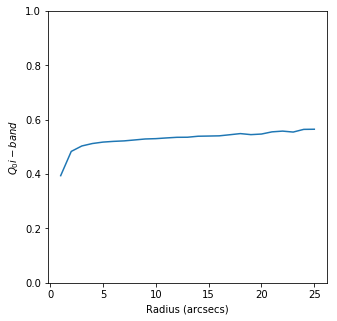

In [25]:
plt.rcParams["figure.figsize"] = (5,5)
plot(rads, q_0_rad_i)
xlabel("Radius (arcsecs)")
ylabel("$Q_0 i-band$")
ylim([0, 1]);

### W1-band

In [26]:
q_0_comp_w1 = Q_0(coords_lofar, coords_combined[combined_w1], field)

In [27]:
q_0_rad_w1 = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w1(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w1.append(np.mean(q_0_rad_aux))
    print("{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(radius, 
            np.mean(q_0_rad_aux), np.std(q_0_rad_aux), 
            np.min(q_0_rad_aux), np.max(q_0_rad_aux)))

 1 0.48528 +/- 0.00013 [0.48502 0.48546]
 2 0.63373 +/- 0.00010 [0.63358 0.63391]
 3 0.67774 +/- 0.00018 [0.67742 0.67798]
 4 0.69997 +/- 0.00025 [0.69936 0.70034]
 5 0.71345 +/- 0.00042 [0.71300 0.71422]
 6 0.72368 +/- 0.00034 [0.72299 0.72415]
 7 0.73504 +/- 0.00033 [0.73461 0.73573]
 8 0.74619 +/- 0.00047 [0.74556 0.74696]
 9 0.75823 +/- 0.00030 [0.75797 0.75892]
10 0.76719 +/- 0.00046 [0.76662 0.76809]
11 0.77414 +/- 0.00034 [0.77366 0.77459]
12 0.77706 +/- 0.00069 [0.77573 0.77812]
13 0.78045 +/- 0.00086 [0.77838 0.78151]
14 0.78377 +/- 0.00064 [0.78290 0.78479]
15 0.78532 +/- 0.00083 [0.78416 0.78703]
16 0.78580 +/- 0.00095 [0.78438 0.78740]
17 0.78524 +/- 0.00114 [0.78276 0.78676]
18 0.78352 +/- 0.00110 [0.78125 0.78569]
19 0.78376 +/- 0.00123 [0.78201 0.78612]
20 0.78243 +/- 0.00187 [0.77898 0.78465]
21 0.77945 +/- 0.00138 [0.77685 0.78243]
22 0.77808 +/- 0.00188 [0.77507 0.78093]
23 0.77228 +/- 0.00195 [0.76921 0.77522]
24 0.77022 +/- 0.00298 [0.76421 0.77438]
25 0.76521 +/- 0

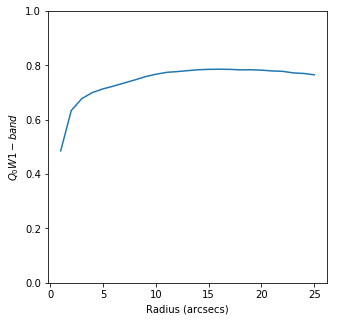

In [28]:
plt.rcParams["figure.figsize"] = (5,5)
plot(rads, q_0_rad_w1)
xlabel("Radius (arcsecs)")
ylabel("$Q_0 W1-band$")
ylim([0, 1]);